# 1) Import the data

In [54]:
import pandas as pd

jan_df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet' ,engine='pyarrow')
feb_df = pd.read_parquet('../data/fhv_tripdata_2021-02.parquet' ,engine='pyarrow')

# Q1 - Read the data for January. How many records are there?
- [ ]1054112
- [X]1154112 
- [ ]1254112
- [ ]1354112

In [55]:
print(f"January has: {len(jan_df)} records.")

January has: 1154112 records.


In [56]:
print(f"Features: {jan_df.columns}")

Features: Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')


In [57]:
jan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In order to calculate the duration we should only subtract `dropOff_datetime` from `pickup_datetime`.

In [58]:
jan_df['duration'] = jan_df['dropOff_datetime'] - jan_df['pickup_datetime']
jan_df['duration'] = jan_df['duration'].dt.total_seconds() / 60.

# 1.1) Analyze duration

# Q2 - What's the average trip duration in January?

- [ ] 15.16
- [X] 19.16
- [ ] 24.16
- [ ] 29.16


In [59]:
jan_df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

we should focus on durations that are at least one minute and less than 60 minutes.

In [60]:
mask = (jan_df['duration'] >=1) & (jan_df['duration'] <= 60)
jan_df_hour = jan_df[mask]

# Q3 - What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

- [ ] 53%
- [ ] 63%
- [ ] 73%
- [X] 83%

In [87]:
categorical = ['PUlocationID', 'DOlocationID']
numerical = []
features = categorical + numerical
jan_df_train = jan_df_hour[features]
jan_df_train.isna().sum() / len(jan_df_train)

PUlocationID    0.835273
DOlocationID    0.133270
dtype: float64

Fill NA with `-1`

In [88]:
jan_df_train = jan_df_train.fillna(-1)
jan_df_train.isna().sum() / len(jan_df_train)

PUlocationID    0.0
DOlocationID    0.0
dtype: float64

In [89]:
jan_df_train[categorical] = jan_df_train[categorical].astype(str)

# Apply Dictionary Vectorizer

In [73]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
train_dicts = jan_df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Q4 - What's the dimensionality of this matrix? (The number of columns).

- [ ] 2
- [ ] 152
- [ ] 352
- [X] 525
- [ ] 725

In [74]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [75]:
len(dv.get_feature_names_out())

525

# Define target

In [76]:
target = 'duration'
y_train = jan_df_train[target].values

# Model

In [77]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [78]:
y_pred = lr.predict(X_train)

/home/nahum/Documents/mlops-zoomcamp/.env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nahum/Documents/mlops-zoomcamp/.env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


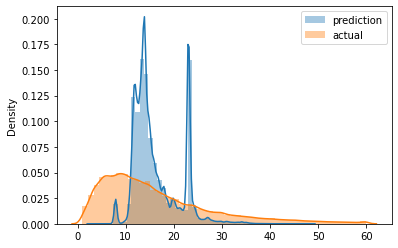

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_pred, squared=False)

10.528519395264997

Q5 - What's the RMSE on train?

- [ ]5.52
- [X]10.52
- [ ]15.52
- [ ]20.52

# Refactoring the code

In [96]:
def read_data(filename: str):
    df = pd.read_parquet(filename ,engine='pyarrow')
    
    df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
    df['duration'] = df['duration'].dt.total_seconds() / 60.

    mask = (df['duration'] >= 1) & (df['duration'] <= 60)
    df = df[mask]

    categorical = ['PUlocationID', 'DOlocationID']
    # df = df[categorical]
    df = df.fillna(-1)
    df[categorical] = df[categorical].astype(str)
    
    return df

In [112]:
df_train = read_data('../data/fhv_tripdata_2021-01.parquet')
df_val = read_data('../data/fhv_tripdata_2021-02.parquet')
df_train.shape, df_val.shape

((1109826, 8), (990113, 8))

In [116]:
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from typing import List, Tuple

from typing import Protocol

class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...

def train_model(train_data: pd.DataFrame, features: List[str],
                target: str) -> Tuple[DictVectorizer, ScikitModel]:
    
    _df = train_data.copy()
    # One hot encode categorical data
    # maybe it's best to abstract X_train from the training
    dv = DictVectorizer()
    train_dicts = _df[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    # Predict target value
    y_train = _df[target].values

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return dv, lr

def evaluate_model(model: ScikitModel, X: np.array, y_true: np.array) -> float:
    y_pred = model.predict(X)
    return mean_squared_error(y_true, y_pred, squared=False)

In [117]:
# Train the model
features = ['PUlocationID', 'DOlocationID']
target = 'duration'
dv, lr = train_model(df_train, features=features, target=target)

In [118]:
# Evaluate the model
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.transform(train_dicts)
y_train = df_train[target]
evaluate_model(lr, X_train, y_train)

10.528519395264997

In [121]:
# Saving the model

import pickle

with open('../models/lin_reg.pkl', 'wb') as file:
    pickle.dump((dv, lr), file)

# Q6 - What's the RMSE on validation?

- [ ] 6.01
- [x] 11.01
- [ ] 16.01
- [ ] 21.01

In [119]:
# Evaluate the model
val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target]
evaluate_model(lr, X_val, y_val)

11.014287010952778